<a href="https://colab.research.google.com/github/rahiakela/nlp-research-and-practice/blob/main/text-similarity-works/21_keyword_semantic_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Keyword Semantic Search

In [ ]:
!pip install sentence_transformers
!pip install nmslib

In [14]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

import spacy
from spacy.matcher import Matcher

import nmslib

#from outdoors import *
#from plotnine import *

import pandas as pd
import pickle
import json
import tqdm
from IPython.display import display,HTML
pd.set_option('display.max_rows', 1000)

##Load Dataset

In [5]:
icd_9_df = pd.read_csv('icd_9_code_and_kerwords.csv')
icd_9_df.head()

,Code,Keyword
0,001.0,Cholera due to vibrio cholerae
1,001.1,Cholera due to vibrio cholerae el tor
2,001.9,Cholera unspecified
3,002.0,Typhoid fever
4,002.1,Paratyphoid fever A


In [6]:
print(len(icd_9_df))

18449


In [7]:
icd_10_df = pd.read_csv('icd_10_code_and_keywords_v3.csv')
icd_10_df.head()

,Code,Keyword,SynId,Field_Target
0,S60.879,Other superficial bite of unspecified wrist,INJ11,Wound_Type
1,S60.879A,"Other superficial bite of unspecified wrist, i...",INJ11,Wound_Type
2,S60.879D,"Other superficial bite of unspecified wrist, s...",INJ11,Wound_Type
3,S60.879S,"Other superficial bite of unspecified wrist, s...",INJ11,Wound_Type
4,S60.9,"Unspecified superficial injury of wrist, hand ...",INJ3,Injury_Location


In [8]:
len(icd_10_df)

96745

##Loading model

In [ ]:
stsb = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

In [10]:
print(stsb)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': True}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


##Getting Embeddings

In [11]:
icd_9_keyword_embeddings_pickle = "icd_9_keyword_embeddings.pickle"
icd_10_keyword_embeddings_pickle = "icd_10_keyword_embeddings.pickle"

In [12]:
def get_embeddings(sentences, load_from_cache=True):
  if not load_from_cache:
    embeddings = stsb.encode(sentences, convert_to_tensor=True)
    with open(icd_9_keyword_embeddings_pickle, "wb") as fd:
      pickle.dump(embeddings, fd)
  else:
    with open(icd_9_keyword_embeddings_pickle, "rb") as fd:
      embeddings = pickle.load(fd)
  return embeddings

In [13]:
# Encode the keywords into embeddings
keywords = list(filter(None, list(icd_9_df["Keyword"])))
embeddings = get_embeddings(keywords, load_from_cache=False).cpu().numpy()

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 18449
Dimensions per embedding: 768


##Calculate similarity

In [15]:
# let's find the pairs with the highest cosine similarity scores
similarities = util.pytorch_cos_sim(embeddings[0:100], embeddings[0:100])
print(f"The shape of the resulting similarities: {similarities.shape}")

The shape of the resulting similarities: torch.Size([100, 100])


In [19]:
a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities) - 1):
  for b in range(a + 1, len(similarities)):
    a_phrases.append(keywords[a])
    b_phrases.append(keywords[b])
    scores.append(float(similarities[a][b]))

comparisons_df = pd.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases, "score": scores})
comparisons_df = comparisons_df.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons_df[comparisons_df["score"] > .9]

,phrase a,phrase b,score
0,Paratyphoid fever A,Paratyphoid fever C,0.982230
1,Intestinal infection due to enteropathogenic E...,Intestinal infection due to enterotoxigenic E....,0.980808
2,Primary tuberculous infection tubercle bacilli...,Other primary progressive tuberculosis tubercl...,0.973134
3,Intestinal infection due to enteropathogenic E...,Intestinal infection due to enteroinvasive E. ...,0.966536
4,Intestinal infection due to enterotoxigenic E....,Intestinal infection due to enteroinvasive E. ...,0.961821
5,Paratyphoid fever B,Paratyphoid fever C,0.953546
6,Paratyphoid fever A,Paratyphoid fever B,0.952772
7,Primary tuberculous infection tubercle bacilli...,Tuberculous pleurisy in primary progressive tu...,0.952296
8,Tuberculous pleurisy in primary progressive tu...,Other primary progressive tuberculosis tubercl...,0.947442
9,Primary tuberculous infection tubercle bacilli...,Other primary progressive tuberculosis tubercl...,0.946956


##Nearest-Neighbor search

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [20]:
# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method="hnsw", space="cosinesimil")
index.addDataPointBatch(embeddings)
index.createIndex(print_progress=True)

In [21]:
keywords[25]

'Botulism food poisoning'

In [22]:
# Example query for the new index.  The 25th embedding is the term 'bag'
ids, distances = index.knnQuery(embeddings[25], k=10)
matches = [keywords[idx] for idx in ids]
print(matches)

['Botulism food poisoning', 'Other bacterial food poisoning', 'Benign carcinoid tumor of the stomach', 'Benign carcinoid tumor of the descending colon', 'Accidental poisoning by barbiturates', 'Food poisoning due to Vibrio parahaemolyticus', 'Accidental poisoning by insecticides of organochlorine compounds', 'Staphylococcal food poisoning', 'Accidental poisoning by insecticides of organophosphorus compounds', 'Administration of botulism antitoxin']


In [24]:
keywords[21]

'Shigella sonnei'

In [25]:
# Example query for the new index.  The 21th embedding is the term 'work'
ids, distances = index.knnQuery(embeddings[21], k=10)
matches = [keywords[idx] for idx in ids]
print(matches)

['Shigella sonnei', 'Shigella flexneri', 'Shigella boydii', 'Shigella dysenteriae', 'Shigellosis unspecified', 'Removal of remaining testis', 'Closed fracture of shaft of radius (alone)', 'Other specified Shiga toxin-producing Escherichia coli [E. coli] (STEC)', 'Division of endometrial synechiae', 'Nezelofs syndrome']


In [26]:
def print_labels(prefix, matches):
  display(HTML('<h4>Results for: <em>'+prefix+'</em></h4>'))
  for l,d in matches:
    print(str(int(d*1000)/1000), '|', l)

In [27]:
# let's create a method that accepts any query whether or not it’s already in our dictionary
def semantic_search(query, k=20, minimum_similarity=0.6):
  matches = []
  embeddings = stsb.encode([query], convert_to_tensor=True)
  ids, distances = index.knnQuery(embeddings[0].cpu().numpy(), k=k)
  for id in range(len(ids)):
    text = keywords[ids[id]]
    distance = 1.0 - distances[id]
    if distance > minimum_similarity:
      matches.append((text, distance))
  if not len(matches):
    matches.append((keywords[ids[1]], 1.0 - distances[1]))
  print_labels(query, matches)

In [28]:
semantic_search("Shigella sonnei")

1.0 | Shigella sonnei
0.626 | Shigella flexneri
0.623 | Shigella boydii


In [29]:
embeddings.shape

(18449, 768)

In [ ]:
semantic_search("campfire")

0.784 | Is campfire smoke safe for inhalation and cooking?
0.736 | Cooking over a fire
0.709 | Camping in (US) national forests
0.709 | How to create campfire which will burn overnight?
0.707 | Activities at the campsite
0.705 | How should I put out a campfire while away from civilization?
0.673 | Using Camphor (Icy Hot) in the winter for warmth
0.657 | Camping stove with plane allowed fuel
0.652 | How to make a fire in the wild, without burning the ground?
0.652 | Camp fire starting for the novice?
0.65 | Grilling in the wilderness
0.646 | Dispersed camping allowing gathered wood fires within 5 hours of San Francisco?
0.645 | Camping site suggestions
0.642 | Are there any techniques to cooking food when camping in the wild by harnessing the energy of the sun?
0.626 | How do you build a campfire that leaves no trace?
0.623 | Which camp fuel type is the easiest on your stove?
0.617 | What are important components of a camp kitchen?
0.61 | Car camping meal ideas?
0.601 | How to make a fi

In [ ]:
semantic_search("dehyd")

0.633 | The re-hydration time for deydrated foods


In [ ]:
semantic_search("compa")

0.468 | Acclimatization strategies


In [ ]:
semantic_search("excer")

0.399 | Outer Layer Recommendation Question


##Visualize 3d vector space

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

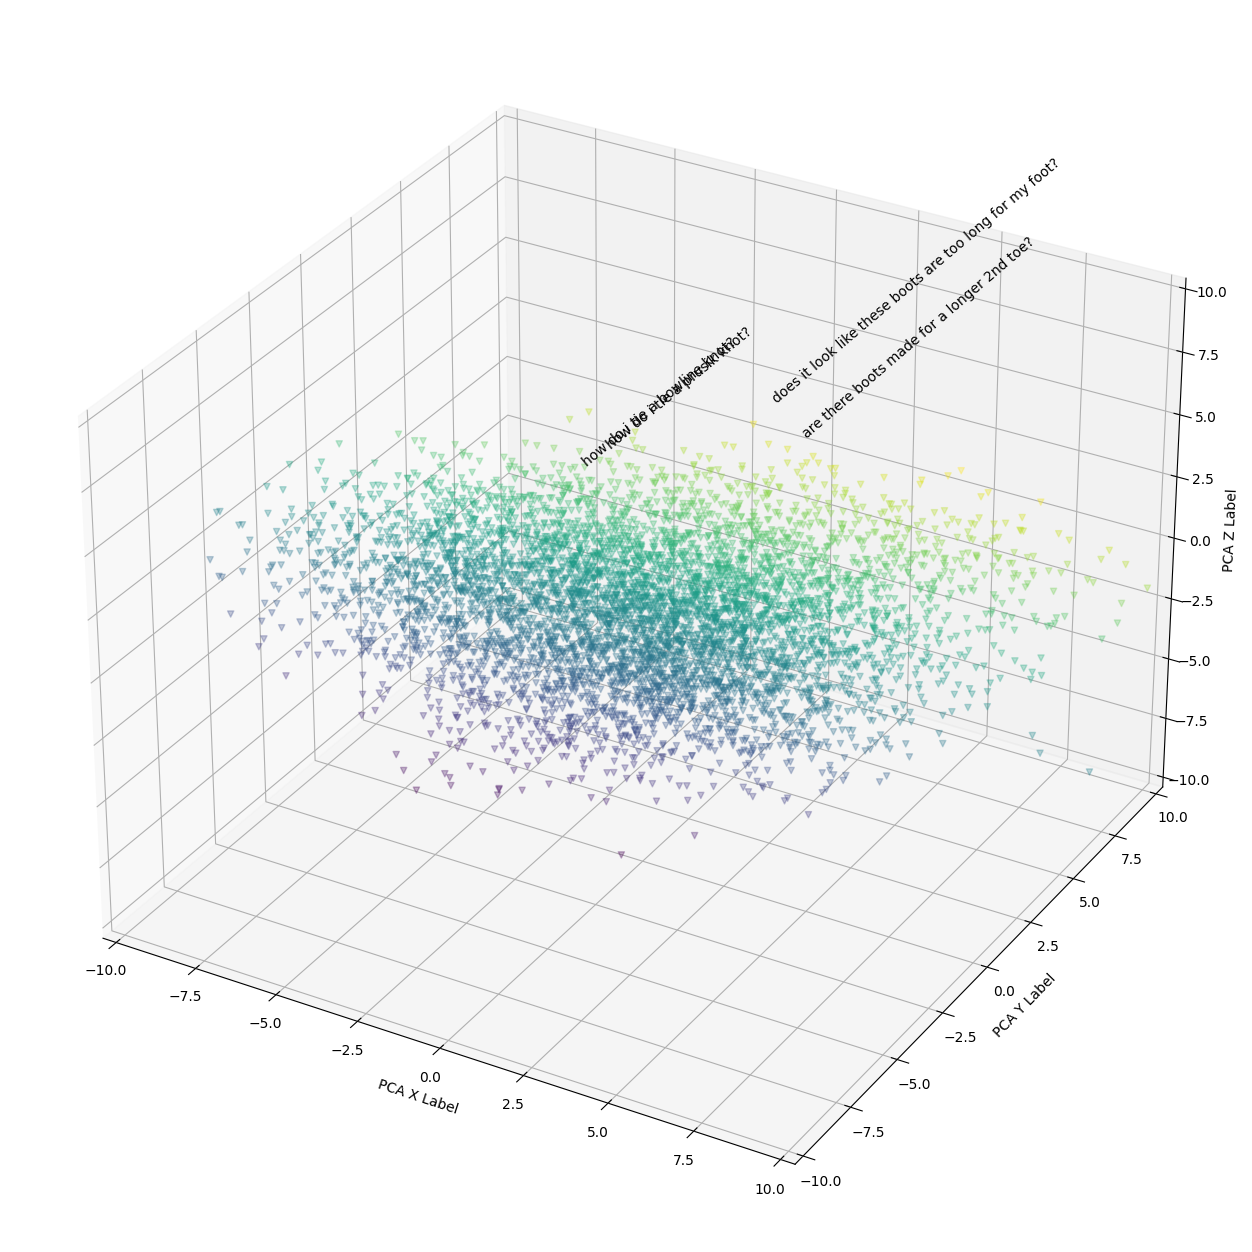

In [ ]:
vectors = embeddings
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = index.knnQuery(embeddings[100], k=2)
label_ids += [idx for idx in ids]
ids,_ = index.knnQuery(embeddings[505], k=2)
label_ids += [idx for idx in ids]
label_texts += [titles[idx].lower() for idx in label_ids]
markers = ['v']*len(vectors)

components = pd.DataFrame({
    'x': pca_data[:,0],
    'y': pca_data[:,1],
    'z': pca_data[:,2]
})

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    components['x'].values,
    components['y'].values,
    c=components['y'].values,
    marker='v',
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components['x'][i]
    y = components['y'][i]
    z = components['z'][i]
    zdir = 'y'
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel('PCA X Label')
ax.set_ylabel('PCA Y Label')
ax.set_zlabel('PCA Z Label')
plt.show()